In [ ]:
import os
from glob import glob
import torch
import torchio as tio

import numpy as np
from PIL import Image

%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

from mgmt.data.nifti import load_subjects

from mgmt.data.subject_transforms import largest_tumor_crop_bounds, tumor_crop_dimensions
from mgmt.utils.segmentation import find_objects_fixed_crop, make_label_mask
from mgmt.visualize.subject import plot_volume_with_label

import scipy
from collections import defaultdict
from tqdm import tqdm

from mgmt.transforms.rescale_intensity import RescaleIntensity

In [ ]:
subjects = load_subjects("/home/bryan/data/brain_tumor/caidm_3d_240","/home/bryan/data/brain_tumor/classification/train_labels.csv" )

In [73]:
for subject in subjects:
    if subject.patient_id_str == "MGMT-006878":
        break

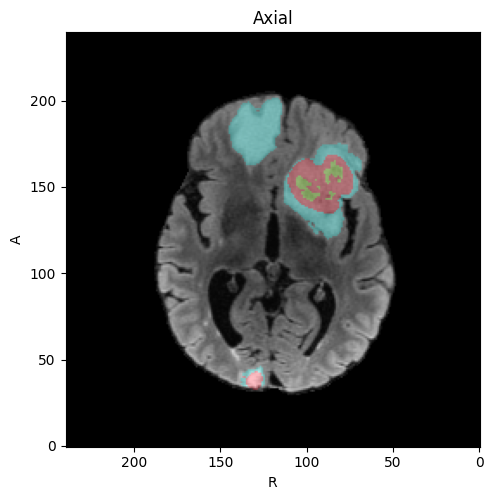

In [74]:
fig = plot_volume_with_label(subject.fla, subject.tumor, single_axis="axial");

In [75]:
sub_canonical = tio.ToCanonical()(subject)

In [88]:
sub_intensity_mask = RescaleIntensity(
    out_min_max=(-1, 1),
    percentiles=(0.5, 99.5),
    masking_method= lambda x: x > 0.0
)(sub_canonical)

In [80]:
# fig = plot_volume_with_label(sub_intensity_mask.fla, sub_intensity_mask.tumor, single_axis="axial");

In [78]:
sub_affine = tio.RandomAffine(
    # could consider slightly rescaling of (0.75, 1.25, 0.75, 1.25, 1, 1)
    scales=(1, 1, 1, 1, 1, 1),
    # only rotate about the z-axis (depth)
    degrees=(0, 0, 0, 0, 0, 360),
)(sub_intensity_mask)

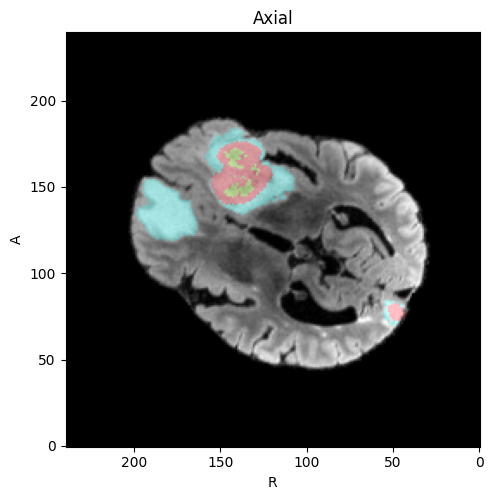

In [79]:
fig = plot_volume_with_label(sub_affine.fla, sub_affine.tumor, single_axis="axial");

In [95]:
sub_noise = tio.RandomNoise(p=0.5, std=(0, 0.25))(subject)


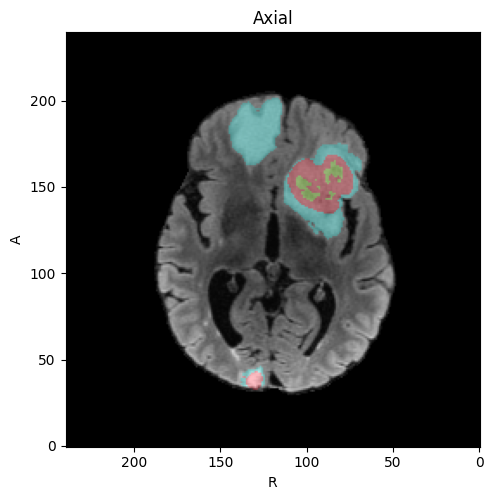

In [96]:
fig = plot_volume_with_label(sub_noise.fla, sub_noise.tumor, single_axis="axial");

In [87]:
sub_noise.fla.data.min()

tensor(-0.9712)

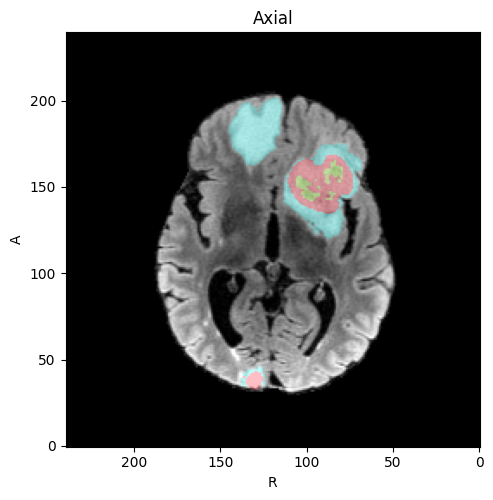

In [89]:
fig = plot_volume_with_label(sub_intensity_mask.fla, sub_intensity_mask.tumor, single_axis="axial");

In [109]:
sub_noise = tio.RandomNoise(p=1.0, std=(0, 1.0))(sub_intensity_mask)

In [110]:
sub_noise2 = RescaleIntensity(
    out_min_max=(-1, 1),
    percentiles=(0.5, 99.5),
#     masking_method= lambda x: x > 0.0
)(sub_noise)

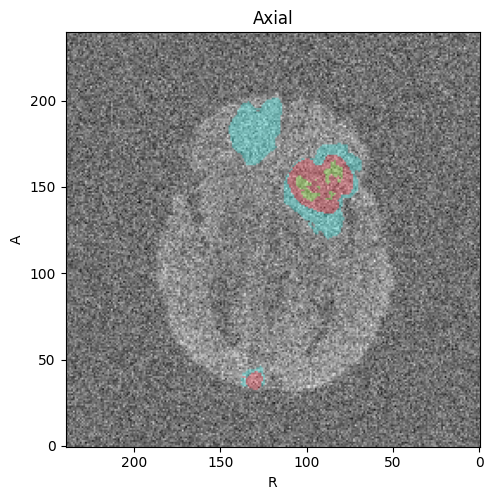

In [111]:
fig = plot_volume_with_label(sub_noise.fla, sub_noise.tumor, single_axis="axial");

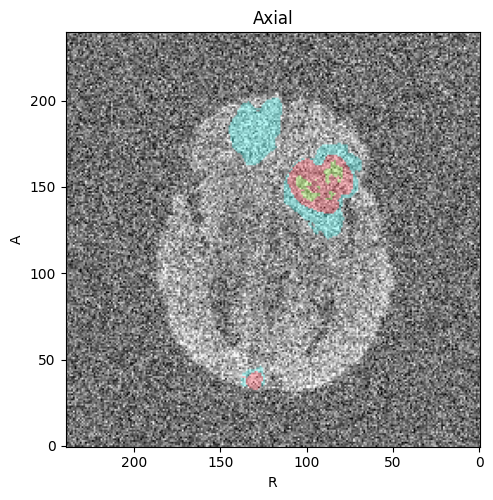

In [112]:
fig = plot_volume_with_label(sub_noise2.fla, sub_noise2.tumor, single_axis="axial");

In [113]:
sub_motion = tio.RandomMotion(p=1, translation=(-1, 1), degrees=(-1, 1))(subject)

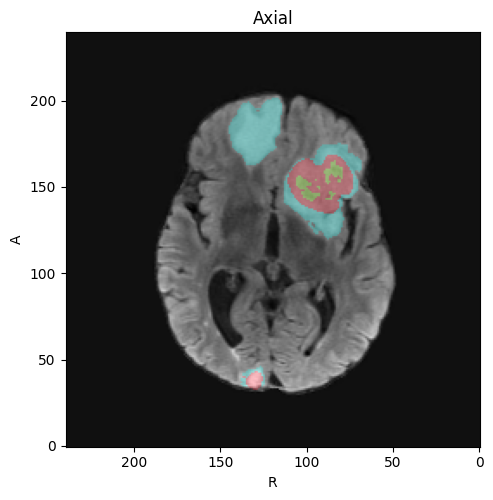

In [114]:
fig = plot_volume_with_label(sub_motion.fla, sub_motion.tumor, single_axis="axial");

In [123]:
sub_bias = tio.RandomBiasField(p=1, coefficients=(-0.5, -0.5))(subject)

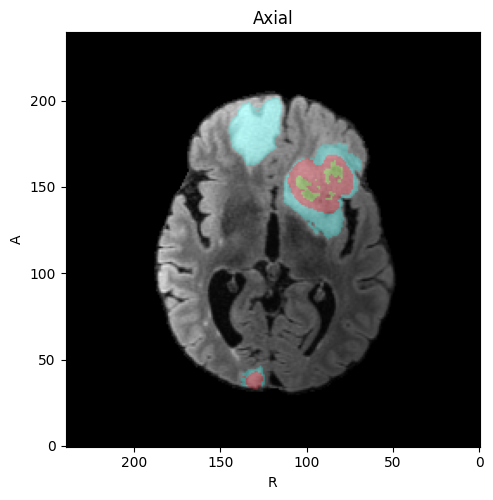

In [124]:
fig = plot_volume_with_label(sub_bias.fla, sub_bias.tumor, single_axis="axial");

In [121]:
for image_name in ('fla', 't1w', 't1c', 't2w'):
    min_ = sub_bias[image_name].data.numpy().min()
    max_ = sub_bias[image_name].data.numpy().max()
    amax = sub_bias[image_name].data.argmax()
    print(image_name, min_, max_, amax)

fla 0.0 35017.2 tensor(5010363)
t1w 0.0 20081.826 tensor(5164245)
t1c 0.0 60147.035 tensor(5086615)
t2w 0.0 53312.727 tensor(5271223)


In [125]:
for image_name in ('fla', 't1w', 't1c', 't2w'):
    min_ = sub_bias[image_name].data.numpy().min()
    max_ = sub_bias[image_name].data.numpy().max()
    amax = sub_bias[image_name].data.argmax()
    print(image_name, min_, max_, amax)

fla 0.0 1919.5366 tensor(3615150)
t1w 0.0 2781.2617 tensor(3514042)
t1c 0.0 5029.6123 tensor(4107709)
t2w 0.0 2629.781 tensor(2362734)


In [122]:
for image_name in ('fla', 't1w', 't1c', 't2w'):
    min_ = subject[image_name].data.numpy().min()
    max_ = subject[image_name].data.numpy().max()
    amax = subject[image_name].data.argmax()
    print(image_name, min_, max_, amax)

fla 0.0 4543.169 tensor(5264688)
t1w 0.0 3857.229 tensor(5597713)
t1c 0.0 7284.137 tensor(5075388)
t2w 0.0 4842.3057 tensor(6534295)


In [64]:
sub_gamma = tio.RandomGamma(log_gamma=(0.5, 0.5), p=1.0)(sub_intensity_mask)

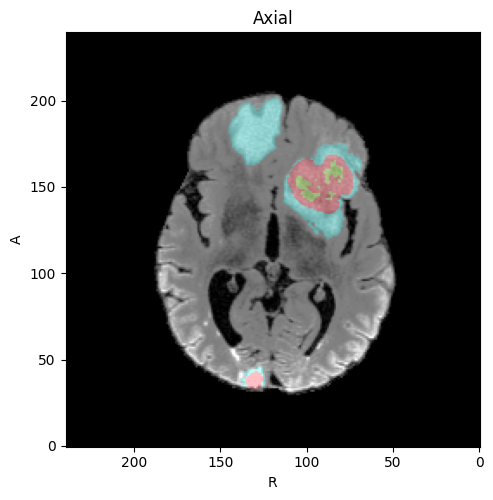

In [65]:
fig = plot_volume_with_label(sub_gamma.fla, sub_gamma.tumor, single_axis="axial");

In [29]:
torch.all(sub_intensity_mask.fla.data.eq(sub_gamma.fla.data))

tensor(False)

In [36]:
sub_gamma.fla.data.min()

tensor(-1.)

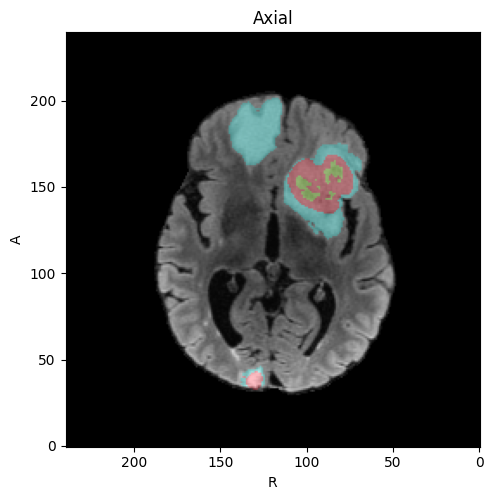

In [50]:
fig = plot_volume_with_label(subject.fla, subject.tumor, single_axis="axial");

In [55]:
subject.fla.data.max()

tensor(4543.1689)

In [66]:
sub_gamma = tio.RandomGamma(log_gamma=(0.5, 0.5), p=1.0)(subject)

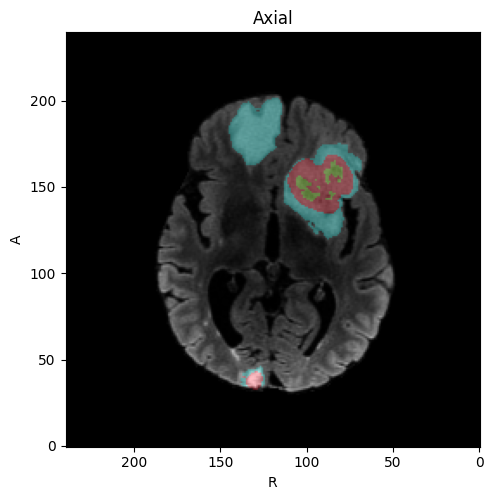

In [67]:
fig = plot_volume_with_label(sub_gamma.fla, sub_gamma.tumor, single_axis="axial");

In [61]:
sub_gamma = tio.RandomGamma(log_gamma=(0.5, 0.5), p=1.0)(subject)

tensor(165.3105)

In [62]:
sub_gamma.fla.data.min()

tensor(0.)

In [68]:
sub_intensity_mask = RescaleIntensity(
    out_min_max=(-1, 1),
    percentiles=(0.5, 99.5),
    masking_method= lambda x: x > 0.0
)(sub_gamma)

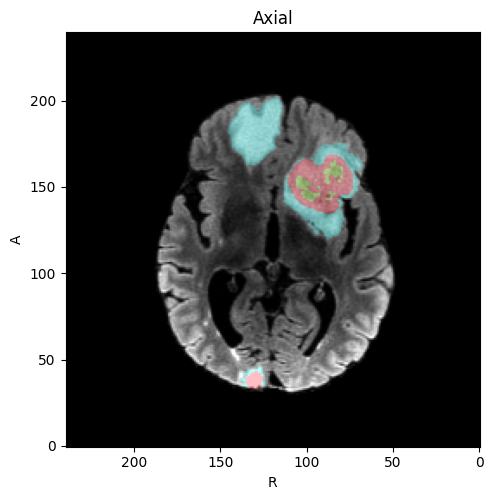

In [69]:
fig = plot_volume_with_label(sub_intensity_mask.fla, sub_intensity_mask.tumor, single_axis="axial");

In [ ]:
for image_name in ('fla', 't1w', 't1c', 't2w'):
    min_ = sub_canonical[image_name].data.numpy().min()
    max_ = sub_canonical[image_name].data.numpy().max()
    amax = sub_canonical[image_name].data.argmax()
    print(image_name, min_, max_, amax)

In [ ]:
sub_intensity = tio.RescaleIntensity(out_min_max=(-1, 1), percentiles=(0, 100))(sub_canonical)

In [ ]:
for image_name in ('fla', 't1w', 't1c', 't2w'):
    min_ = sub_intensity[image_name].data.numpy().min()
    max_ = sub_intensity[image_name].data.numpy().max()
    amax = sub_intensity[image_name].data.argmax()
    print(image_name, min_, max_, amax)

In [ ]:
sub_intensity_mask = tio.RescaleIntensity(
    out_min_max=(-1, 1),
    percentiles=(0, 100),
    masking_method= lambda x: x > 0.0
)(sub_canonical)

In [ ]:
for image_name in ('fla', 't1w', 't1c', 't2w'):
    min_ = sub_intensity_mask[image_name].data.numpy().min()
    max_ = sub_intensity_mask[image_name].data.numpy().max()
    amax = sub_intensity_mask[image_name].data.argmax()
    print(image_name, min_, max_, amax)

In [ ]:
from mgmt.transforms.rescale_intensity import RescaleIntensity

In [ ]:
sub_intensity_mask = RescaleIntensity(
    out_min_max=(-1, 1),
    percentiles=(0, 100),
    masking_method= lambda x: x > 0.0
)(sub_canonical)

In [ ]:
for image_name in ('fla', 't1w', 't1c', 't2w'):
    min_ = sub_intensity_mask[image_name].data.numpy().min()
    max_ = sub_intensity_mask[image_name].data.numpy().max()
    amax = sub_intensity_mask[image_name].data.argmax()
    print(image_name, min_, max_, amax)